# DATA DISTRIBUTION CODE

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

font = {'family':'Bahnschrift', 'fontsize' : 16}

from matplotlib.gridspec import GridSpec as gspec

# %matplotlib inline

## Radon concentrations
Import the radon concentrations measured. (RAW DATA)

In [13]:
DF = pd.read_excel('Dataset for fitting/Raw_Results_LR115.xlsx') # Raw data import

DF_data = DF[(DF['Concentracion_Bq_m3'].notna())] #Drop NA data
DF_data['Error_perc'] = DF_data.apply(lambda df: 100*np.abs(df['Concentracion_Bq_m3'] - df['Contramuestra'])/df['Concentracion_Bq_m3'], axis = 1) #Add error column
DF_data.ID_muestra = DF_data.ID_muestra.apply(lambda df : int(str(df)[:2]))  # conver ID coumn to integer datatype 

# Set index as ID
DF_data = DF_data.set_index('ID_casa')

## Basic statistics
Calculate basic statistics

In [14]:
DF_data = DF_data.iloc[:,-2:] # Get columns of interest

# Geometric mean calculation
Geo_mean = 1 
for i in range(len(DF_data)):
    Geo_mean *= DF_data['Resultado'].iloc[i]
Geo_mean = Geo_mean**(1/len(DF_data))

print('Geometric mean', Geo_mean, '\n')

DF_data.describe().iloc[[1,2,3,7],:] # Print basic stats of dataframe

Geometric mean 90.84756604725008 



,Resultado,Error_perc
mean,115.667333,13.322263
std,80.552708,10.621109
min,15.400000,3.651314
max,407.000000,39.130435


## Compute Residential Rn histogram

C:\Users\mdomi\AppData\Local\Temp\ipykernel_2780\781058336.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,9,1), fontdict = font, fontsize = 16)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_2780\781058336.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['0%','20%', '40%', '60%', '80%', '100%'], fontdict = font, fontsize = 16)


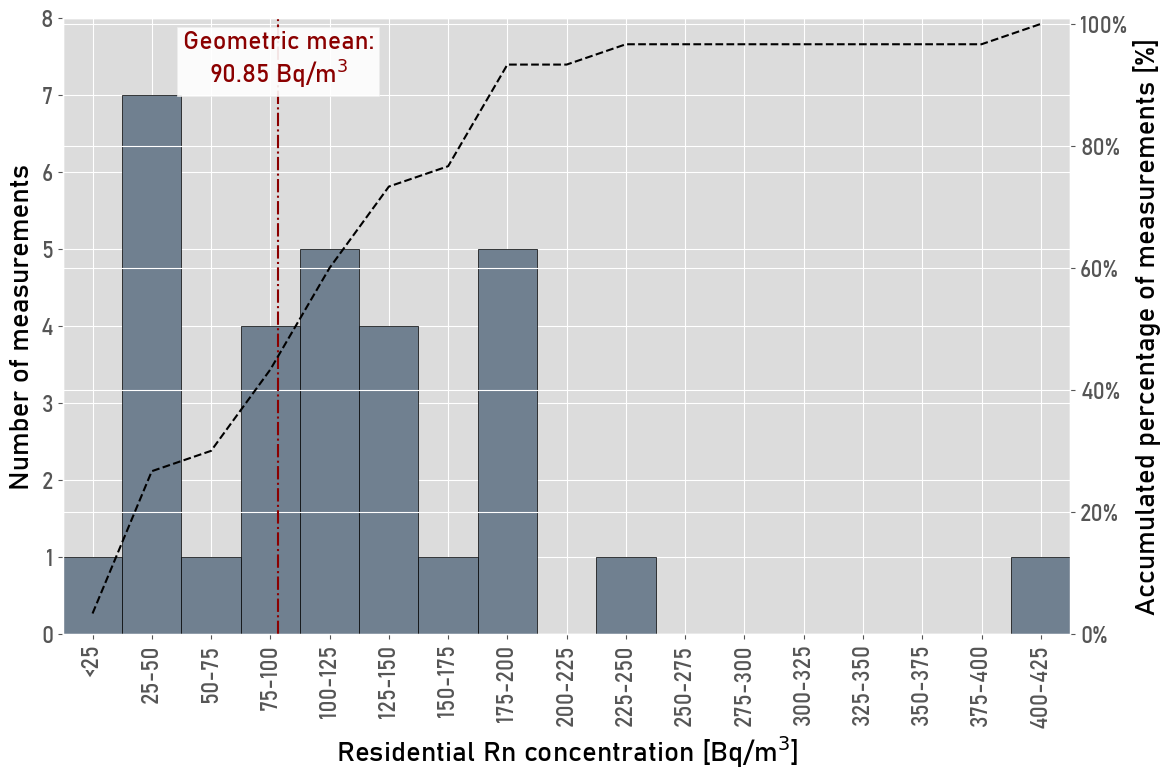

In [15]:
# create figure
fig = plt.figure(figsize = (13,8))

# send grid to back
plt.grid(axis='y', zorder = -1)

# Compute histogram
h = plt.hist(DF_data.Resultado, bins = np.arange(0,450,25), 
             edgecolor = 'k', color = 'slategray', zorder = 4)

# compute median calculation
median = DF_data.median().iloc[0]

# Edit axis
ax = plt.gca()
ax.set_facecolor('gainsboro')

# Edit figure
plt.ylabel('Number of measurements',fontdict = font, fontsize = 20)
plt.xlabel('Residential Rn concentration [Bq/m$^3$]',fontdict = font, fontsize = 20)
plt.xticks(np.arange(12.5,420,25))
ax.set_xticklabels(['<25','25-50','50-75', '75-100', '100-125', '125-150', '150-175', '175-200', '200-225','225-250','250-275',
                    '275-300','300-325','325-350','350-375','375-400','400-425'], fontdict = font, fontsize = 14, rotation = 90)
ax.set_yticklabels(np.arange(0,9,1), fontdict = font, fontsize = 16)
plt.xlim((0,425))
ax.set_ylim((0,8))
# ax.text(3,0.38,'$n=$30', family = 'bahnschrift', fontsize = 16, bbox = {'facecolor':'w','edgecolor':'k'})


#Create second yaxis
ax2 = ax.twinx() 
ax2.set_ylim((0,1.01))

# Plot accumulated prcentage of measurements.
plt.plot(np.arange(12.5,420,25),np.cumsum(h[0])/30, zorder=5, c = 'k', ls ='--')
ax2.set_yticklabels(['0%','20%', '40%', '60%', '80%', '100%'], fontdict = font, fontsize = 16)
ax2.set_ylabel('Accumulated percentage of measurements [%]', fontdict = font, fontsize = 20)

# Plot Geometric mean value
ax2.axvline(Geo_mean, c = 'darkred',ls='-.')
ax2.text(Geo_mean, 0.94,'Geometric mean:\n'+str(round(Geo_mean,2))+' Bq/m$^3$', va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9), family = font['family'], fontsize = 18, color = 'darkred')


# Save figure histogram
fig.savefig('Figures/Rn_Histogram.png', dpi = 150)

## Data distribution with respect to reference values

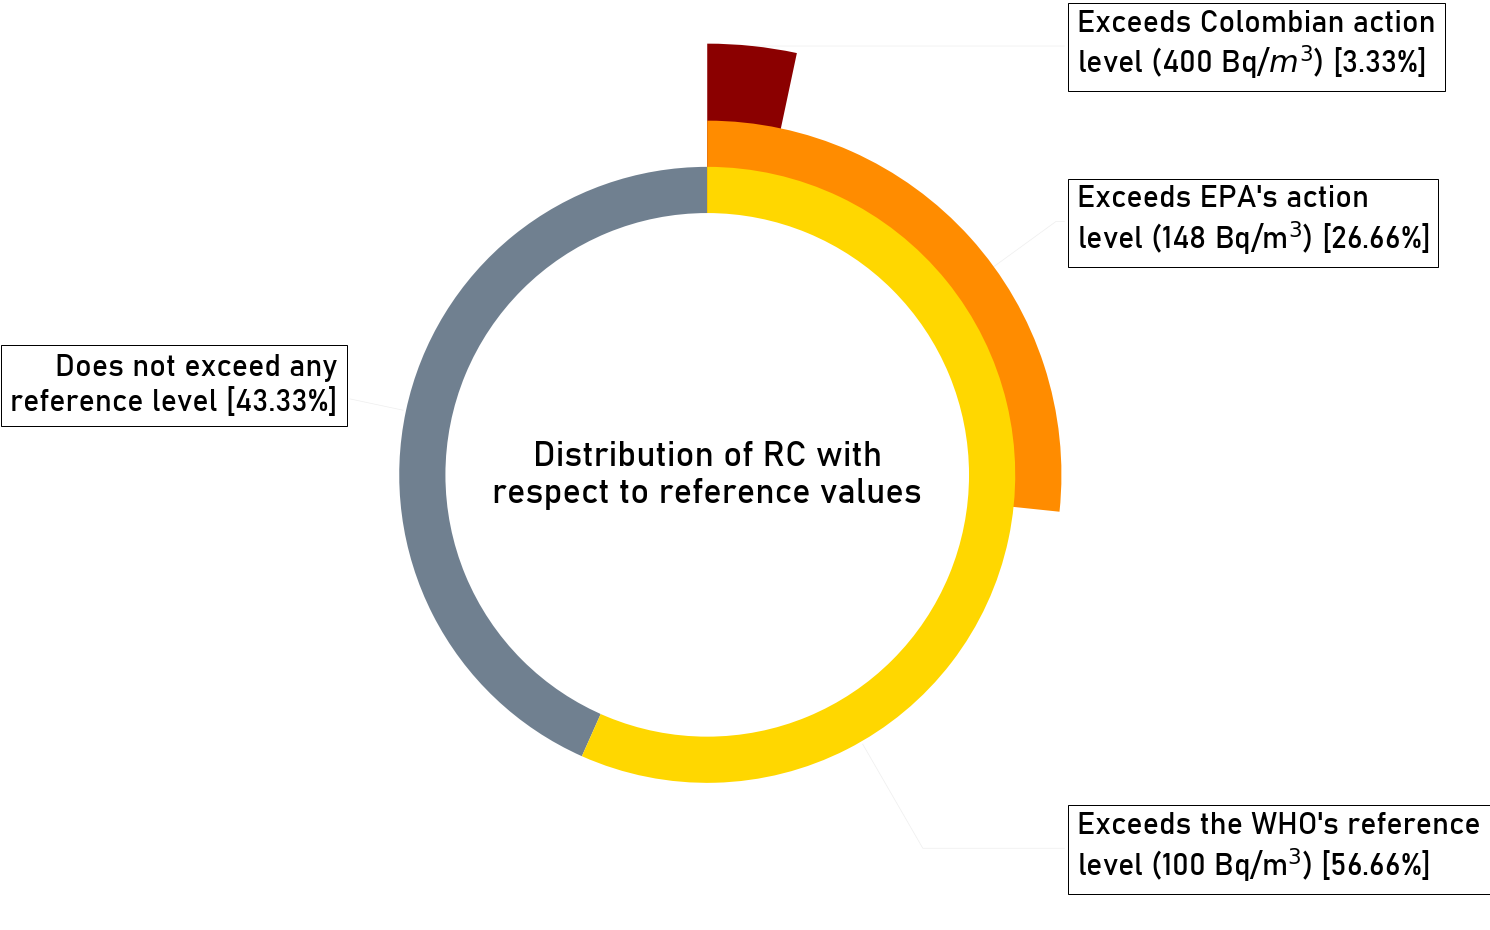

In [16]:
# Data exceeding reference levels of WHO [OMS], EPA an Colombian legislation 
data_exceed = pd.DataFrame(DF_data.Resultado.apply(lambda df : 'Res. 18-1434 de 2002 [400 Bq/$m^3$]' if df > 400 else 'EPA' if df>148 else 'OMS' if df>100 else 'No sobrepasa ningún valor de referencia'))

# Pie plot creation
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
labels = ['Does not exceed any\nreference level', 
          "Exceeds the WHO's reference\nlevel (100 Bq/m$^3$)",
          "Exceeds EPA's action\nlevel (148 Bq/m$^3$)",
          'Exceeds Colombian action\nlevel (400 Bq/$m^3$)']
fig, ax = plt.subplots(figsize = (10,10), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(data_exceed.value_counts(), radius = 1.4
                       , colors = ['w','w','darkorange','darkred'],
                       explode = [-0.8,-0.8,0-0.8,0],startangle = 90, textprops = font)
Perc = [43.33, 56.66, 26.66, 3.33]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i]+' ['+str(round(Perc[i],2))+'%]', xy=(x, y), xytext=(1.2*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw, family = 'bahnschrift', fontsize=22)
    
# plot the pie-plot 
wedges, texts = ax.pie([Perc[0]/100,1-Perc[0]/100-Perc[2]/100, Perc[2]/100], radius = 1.15, colors = ['w','w','darkorange'], explode = [-0.7,-0.7,0], startangle=90)
wedges, texts = ax.pie([Perc[0]/100,1-Perc[0]/100], radius = 1, colors = ['slategray','gold'], startangle=90)
blank_pie = plt.pie([1], radius = 0.85, colors=['w'])

# Set the title
plt.text(0,0,'Distribution of RC with\nrespect to reference values',
         family = 'bahnschrift', fontsize=25, ha = 'center', va = 'center')

# Save figure
plt.savefig('Figures/CompaRefVal.png',dpi = 250, bbox_inches = "tight")

## Data distribution compared with Latin America & the Caribbean measurements

C:\Users\mdomi\AppData\Local\Temp\ipykernel_2780\3168529084.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,10,1), fontdict = font, fontsize = 16)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_2780\3168529084.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['0%','20%', '40%', '60%', '80%', '100%'], fontdict = font, fontsize = 16)


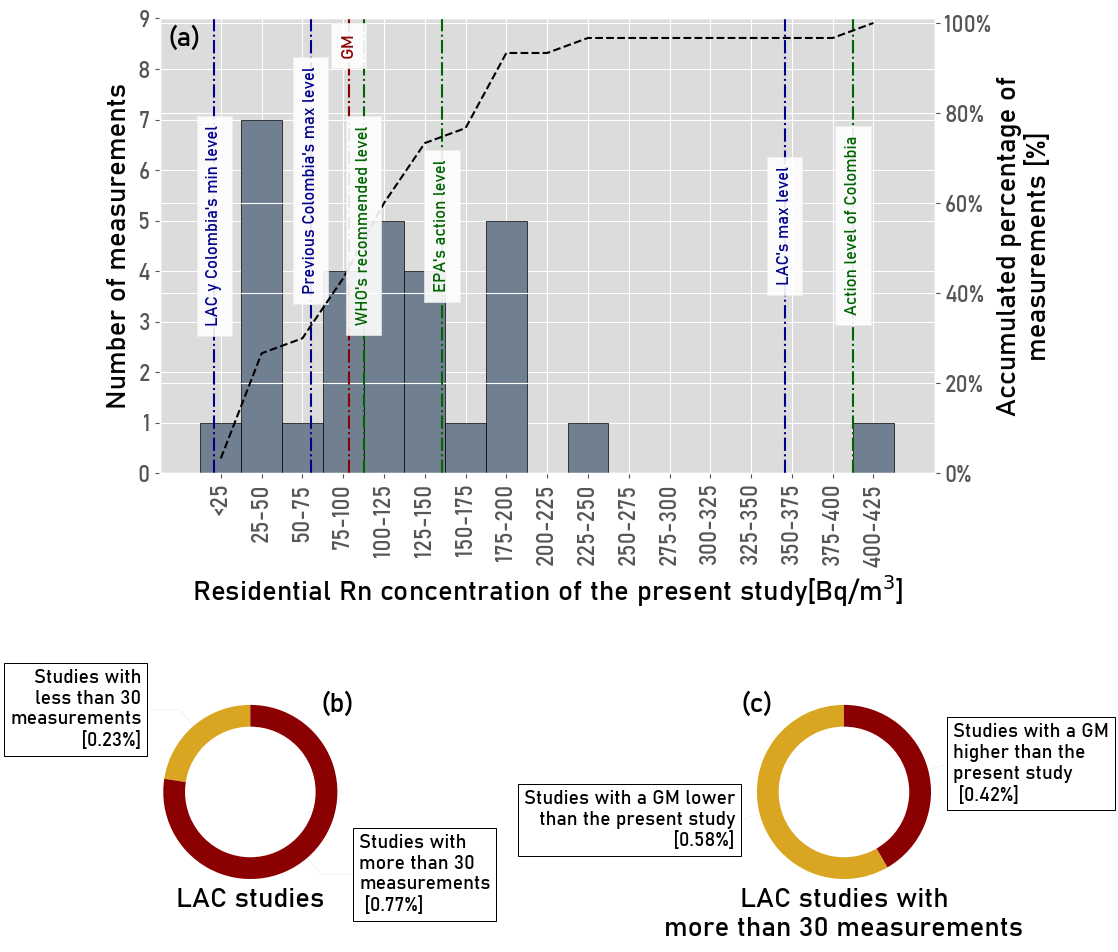

In [17]:
# Create figure
fig = plt.figure(figsize = (10,13))

# Create grid for subplots in figure
plt.subplot2grid((2,8), (0,0), colspan=8)
plt.grid(axis='y', zorder = -1)

# Calculate and histogram values
h = plt.hist(DF_data.Resultado, bins = np.arange(0,450,25), edgecolor = 'k', color = 'slategray', zorder = 4)

# Edit figure properties (frame, labels, ticks, double xaxis etc.)
ax = plt.gca()
ax.set_facecolor('gainsboro')
plt.ylabel('Number of measurements',fontdict = font, fontsize = 20)
plt.xlabel('Residential Rn concentration of the present study[Bq/m$^3$]',fontdict = font, fontsize = 20)
plt.xticks(np.arange(12.5,420,25))
ax.set_xticklabels(['<25','25-50','50-75', '75-100', '100-125', '125-150', '150-175', '175-200', '200-225',
                    '225-250','250-275','275-300','300-325','325-350','350-375','375-400','400-425'], fontdict = font,
                   fontsize = 3, rotation = 90)
ax.set_yticklabels(np.arange(0,10,1), fontdict = font, fontsize = 16)
plt.xlim((-25,450))
ax.set_ylim((0,9))
ax.text(-10,8.6,'(a)', va='center', ha='center',family = 'bahnschrift', fontsize=20,)
ax2 = ax.twinx() 
ax2.set_ylim((0,1.01))

# Plot accumulated percentage lin
plt.plot(np.arange(12.5,420,25),np.cumsum(h[0])/30, zorder=5, c = 'k', ls ='--')
ax2.set_yticklabels(['0%','20%', '40%', '60%', '80%', '100%'], fontdict = font, fontsize = 16)
ax2.set_ylabel('Accumulated percentage of\nmeasurements [%]', fontdict = font, fontsize = 20)

# Plot vline on geometric mean level
ax2.axvline(Geo_mean, c = 'darkred',ls='-.')
ax2.text(Geo_mean, 0.95,'GM', rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 13, color = 'darkred')

# Plot vlines on min and max LAC RC levels
ax2.axvline(8.5, c = 'darkblue',ls='-.')
ax2.text(8.5, 0.55,"LAC y Colombia's min level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkblue')
ax2.axvline(67.5, c = 'darkblue',ls='-.')
ax2.text(67.5, 0.65,"Previous Colombia's max level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkblue')
ax2.axvline(358, c = 'darkblue',ls='-.')
ax2.text(358, 0.55,"LAC's max level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkblue')
ax2.axvline(100, c = 'darkgreen',ls='-.')
ax2.text(100, 0.55,"WHO's recommended level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkgreen', zorder = 6)
ax2.axvline(148, c = 'darkgreen',ls='-.')
ax2.text(148, 0.55,"EPA's action level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkgreen', zorder = 6)
ax2.axvline(400, c = 'darkgreen',ls='-.')
ax2.text(400, 0.55,'Action level of Colombia', rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkgreen', zorder = 6)

# Data of studies with less than 30 measurements (7) and more than 30 measurements (24)
w = [7, 24]

# Plot pie with percentages
ax = plt.subplot2grid((2,8),(1,0), colspan=2)
wedges, texts = plt.pie(w, radius = 1.2, startangle = 90, colors = ['goldenrod', 'darkred'], frame = True)

# Assign labels
labels = ['Studies with\nless than 30\nmeasurements\n', 'Studies with\nmore than 30\nmeasurements\n']
Perc = [w[0]/sum(w), w[1]/sum(w)]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i]+' ['+str(round(Perc[i],2))+'%]', xy=(x, y), xytext=(1.5*np.sign(x), 1.5*y),
                horizontalalignment=horizontalalignment, **kw, family = 'bahnschrift', fontsize=14)

# Edit figure properties
plt.text(1.2,1.2,'(b)', va='center', ha='center',family = 'bahnschrift', fontsize=20)
plt.grid(True)
plt.pie([1], radius=0.9, colors=['w'])
plt.xlabel('LAC studies', family = 'bahnschrift', fontsize=20)

# Data of studies with more than 30 measurements with lower mean RC (14) and higher mean RC (10)
w = [14,10]
ax = plt.subplot2grid((2,8),(1,6), colspan=2)
wedges, texts = plt.pie(w, radius = 1.2, startangle = 90, colors = ['goldenrod', 'darkred'], frame = True)

# Assign labels
labels = ['Studies with a GM lower\n than the present study', 'Studies with a GM\nhigher than the\npresent study']
Perc = [w[0]/sum(w), w[1]/sum(w)]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i]+'\n ['+str(round(Perc[i],2))+'%]', xy=(x, y), xytext=(1.5*np.sign(x), 1.5*y),
                horizontalalignment=horizontalalignment, **kw, family = 'bahnschrift', fontsize=14)
# Edit figure properties
plt.text(-1.2,1.2,'(c)', va='center', ha='center',family = 'bahnschrift', fontsize=20)
plt.grid(True)
plt.pie([1], radius=0.9, colors=['w'])
plt.xlabel('LAC studies with\nmore than 30 measurements', family = 'bahnschrift', fontsize=20)

# Save figure
fig.savefig('Figures/HistogramComparativeDataRegion.png', dpi=250, bbox_inches = 'tight')

C:\Users\mdomi\AppData\Local\Temp\ipykernel_2780\1167330053.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  world_RC = gpd.GeoDataFrame(world_RC[world_RC['IndicatorCode'] == 'RADON_Q302'].groupby('iso_a3').mean().reset_index()[['iso_a3','FactValueNumeric']].merge(world))


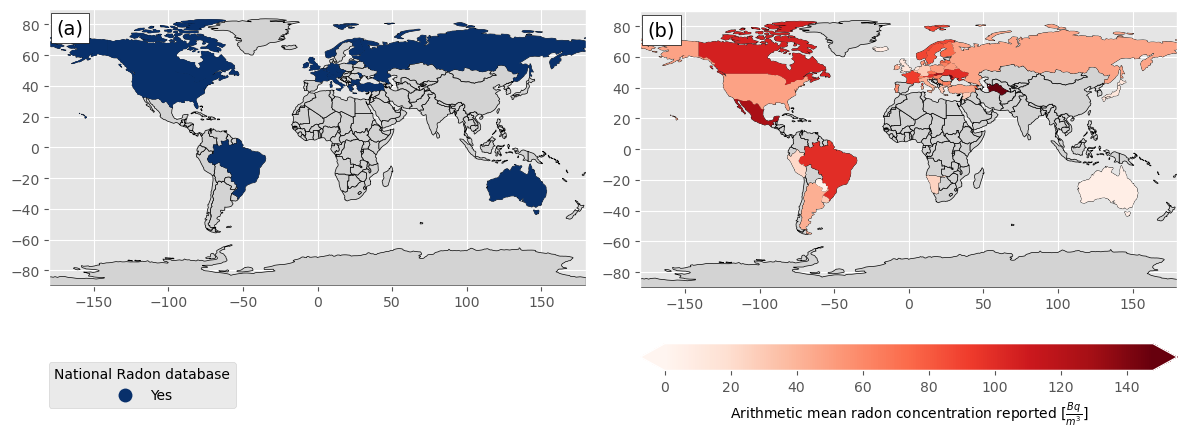

In [18]:
plt.style.use('ggplot')

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

Nat_RC_df = pd.read_csv('National_RC_levels.csv')

fig, ax = plt.subplots(1,2,figsize = (12,6))

world_RC = world.merge(Nat_RC_df, left_on = 'iso_a3', right_on = 'SpatialDimValueCode')
world_RC = gpd.GeoDataFrame(world_RC[world_RC['IndicatorCode'] == 'RADON_Q302'].groupby('iso_a3').mean().reset_index()[['iso_a3','FactValueNumeric']].merge(world))

# PLOT
world.geometry.plot(ax = ax[1], edgecolor = 'k', color = 'lightgray')
world_RC.plot(column = 'FactValueNumeric',
              ax = ax[1], cmap = 'Reds',
              vmin = 0, vmax = 148,
              legend = True,
              legend_kwds = {'extend':'both',
                             'orientation':'horizontal',
                             'label':'Arithmetic mean radon concentration reported $[\\frac{Bq}{m^3}]$',
                             'pad' : 0.1
                            },
              # style_kwds = {'edgecolor' : 'red'}
             )


ax[1].set_xlim(-180,180)
ax[1].set_ylim(-90,90)
world_RC = world.merge(Nat_RC_df, left_on = 'iso_a3', right_on = 'SpatialDimValueCode')
world_RC = world_RC[world_RC['IndicatorCode'] == 'RADON_Q304']
world_RC['DB'] = world_RC.apply(lambda df : df.Value if df.Value == 'Yes' else np.nan,axis = 1)

world.plot(ax = ax[0], edgecolor = 'k', color = 'lightgray', legend = True)
world_RC.plot(column = 'DB',ax = ax[0], cmap = 'Blues_r', legend = True, legend_kwds = {'title':'National Radon database',
                                                                                        'bbox_to_anchor':(0.36,-0.25)})

ax[0].set_xlim(-180,180)
ax[0].set_ylim(-90,90)

ax[0].text(-175,74, '(a)', fontsize = 14, bbox = {'facecolor' : 'white','edgecolor':'k'})
ax[1].text(-175,74, '(b)', fontsize = 14, bbox = {'facecolor' : 'white','edgecolor':'k'})

plt.tight_layout()

fig.savefig('figures/SpatialDist_NationalRCmeasurements.png', dpi = 150, bbox_inches = 'tight')

In [52]:
world_RC = world.merge(Nat_RC_df, left_on = 'iso_a3', right_on = 'SpatialDimValueCode')
world_RC = gpd.GeoDataFrame(world_RC[world_RC['IndicatorCode'] == 'RADON_Q302'].groupby('iso_a3').mean().reset_index()[['iso_a3','FactValueNumeric']].merge(world))
world_RC[world_RC['FactValueNumeric'] > 0].groupby('continent').count()

C:\Users\mdomi\AppData\Local\Temp\ipykernel_2780\2936572801.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  world_RC = gpd.GeoDataFrame(world_RC[world_RC['IndicatorCode'] == 'RADON_Q302'].groupby('iso_a3').mean().reset_index()[['iso_a3','FactValueNumeric']].merge(world))


,iso_a3,FactValueNumeric,pop_est,name,gdp_md_est,geometry
continent,,,,,,
Africa,1,1,1,1,1,1
Asia,5,5,5,5,5,5
Europe,29,29,29,29,29,29
North America,3,3,3,3,3,3
Oceania,1,1,1,1,1,1
South America,5,5,5,5,5,5
